In [627]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import combinations_with_replacement
from scipy.special import comb

np.random.seed(9)

## Load the dataset

In [628]:
data = pd.read_csv(r"Housing.csv")
data  

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [629]:
data.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

## Data Preprocessing

In [630]:
# Convert categorical to numerical features

categorical = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
cat_encodes = {'yes': 1,
               'no': 0}
furnished_stat = ['furnishingstatus']
f_encodes = {
    'furnished': 1,
    'semi-furnished' : 0,
    'unfurnished': -1
}

# Replace all 'yes' with 1 and 'no' with 0 in categorical columns
data[categorical] = data[categorical].replace(cat_encodes)
data[furnished_stat] = data[furnished_stat].replace(f_encodes)

# Display the updated dataframe
data

/var/folders/v0/6fl9_2q93mggh30x_qf5fyv40000gn/T/ipykernel_62594/388020242.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[categorical] = data[categorical].replace(cat_encodes)
/var/folders/v0/6fl9_2q93mggh30x_qf5fyv40000gn/T/ipykernel_62594/388020242.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[furnished_stat] = data[furnished_stat].replace(f_encodes)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,-1
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,0
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,-1
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,1


In [631]:
def test_train_val_split(data, train_split, test_split, val_split):
    
    cols = data.columns
    data = np.array(data)
    
    num_samples = len(data)
    
    indices = np.random.permutation(num_samples)
    
    train_split_indx = int(num_samples * train_split)
    test_split_indx = train_split_indx + int(num_samples * test_split)
    val_split_indx = test_split_indx + int(num_samples*val_split)
    
    train  = data[indices[:train_split_indx]]
    test = data[indices[train_split_indx: test_split_indx]]
    validation = data[indices[test_split_indx: val_split_indx]]
    
    # # Convert numpy arrays back to DataFrames
    # train_df = pd.DataFrame(train, columns=cols)
    # test_df = pd.DataFrame(test, columns=cols)
    # validation_df = pd.DataFrame(validation, columns=cols)
    
    return train, test, validation
    
train, test, valid = test_train_val_split(data, 0.8, 0.1, 0.1)

In [632]:
# Standardize

def standardize(train, test, valid):
    mean = np.mean(train, axis = 0)
    stdev = np.std(train, axis = 0)
    
    train = (train-mean)/stdev    
    test = (test-mean)/stdev   
    valid = (valid-mean)/stdev   

    
    return train, test, valid

def min_max_scaling(train, test, valid):
    min_val = np.min(train, axis=0)
    max_val = np.max(train, axis=0)
    
    train = (train - min_val) / (max_val - min_val)
    test = (test - min_val) / (max_val - min_val)
    valid = (valid - min_val) / (max_val - min_val)
    
    return train, test, valid



In [633]:
def split_features_target(data):
    target = data[:, 0]
    features = data[:, 1:len(data[0])]
    return features, target

# X, y = split_features_target(train)

train, train_target = split_features_target(train)
test, test_target = split_features_target(test)
valid, valid_target = split_features_target(valid)

In [634]:
# train, test, valid = standardize(train, test, valid)
train, test, valid = min_max_scaling(train, test, valid)

In [635]:
class MultivariatePolynomialRegression:
    def __init__(self, learning_rate, degree):
        self.learning_rate = learning_rate
        self.degree = degree
        self.num_combs = None
        self.W = None
        self.B = None
        
    def generate_multivariate_polynomial_features(self, X):

        n_samples = X.shape[0]
        n_features = X.shape[1]
        feature_combinations = []
    
        for d in range(1, self.degree + 1):
            feature_combinations.extend(combinations_with_replacement(range(n_features), d))
            
        poly_features = np.ones((n_samples, len(feature_combinations)))

        for i, comb in enumerate(feature_combinations):
            poly_features[:, i] = np.prod(X[:, comb], axis=1)
        return poly_features                          
        
        
    def initialise_params(self, X):
        # self.W = np.random.randn(n_features)*0.01
        fc = []
        for d in range(1, self.degree + 1):
            fc.extend(combinations_with_replacement(range(len(X[0])), d))
        
        self.num_combs = len(fc)
        self.W = np.random.randn(self.num_combs)*0.01
        self.B = 0
        
    def forward_pass(self, X):
        return np.dot(X, self.W)
    
    # Loss functions
    def mse_error_fn(self, predictions, y):
        m = len(predictions)
        error = np.sum(np.square(predictions - y))/(2 * m)
        return error
    
    def lasso_regularization(self, predictions, y, penalty_control = 0.5):
        lasso_loss = self.mse_error_fn(predictions, y) + np.multiply(penalty_control, abs(np.sum((self.W))))
        return np.log(lasso_loss)
    
    def ridge_regularization(self, predictions, y, penalty_control = 0.5):
        ridge_loss = self.mse_error_fn(predictions, y) + np.multiply(penalty_control, np.sum(np.square(self.W)))
        return np.log(ridge_loss)
    
    def r2_score(self, predictions, y):
        m = len(predictions)
        mean_y = np.mean(y)
        r2 = 1 - ((np.square(y - predictions))/(np.square(y - mean_y)))
        return np.mean(r2)
    
    def backprop(self, predictions, y):
        m = len(predictions) 
        error = predictions - y  
        self.dl_dw = np.dot(self.X.T, error) / m  
        self.dl_db = np.mean(error)

        
    
    def fitting(self, X, y, iters):
        
        self.X = self.generate_multivariate_polynomial_features(X)
        self.y = y
        
        self.initialise_params(X)
        
        costs = []
        
        X = self.X
        
        for i in range(iters):
            predictions = self.forward_pass(X)
            
            cost = self.ridge_regularization(predictions, y, 1)
            r2 = self.r2_score(predictions, y)
            
            self.backprop(predictions, y)
            
            self.W -= self.learning_rate*self.dl_dw
            # self.B -= self.learning_rate*self.dl_db
            
            costs.append(cost)
            
            
            if i % 2 == 0:
                print(f"Iteration: {i}  Loss: {cost} R^2: {r2}")
                
            # if i > 0 and abs(costs[-1] - costs[-2]) < self.stopping_threshold:
            #     print(f"Converged after {i} iterations")
            #     break  
            
        return costs
            
    def plot_lc(self, costs):
        plt.plot(costs)
        plt.title('Learning Curve (Cost vs. Iterations) - Linear Regression')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.show()
        
    def plot(self, data_x, data_y):
        # Get the predictions from the model
        poly_features = self.generate_multivariate_polynomial_features(data_x)
        preds = self.forward_pass(poly_features)
        
        # Sort data based on actual values for better visualization
        sorted_indices = np.argsort(data_y)
        sorted_data_y = data_y[sorted_indices]
        sorted_preds = preds[sorted_indices]
        
        # Scatter plot of Actual vs. Predicted values
        plt.scatter(sorted_data_y, sorted_preds, color='blue', label='Predicted vs Actual')
        
        # Add a reference diagonal (y = x)
        min_val = min(sorted_data_y.min(), sorted_preds.min())
        max_val = max(sorted_data_y.max(), sorted_preds.max())
        plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label='Ideal Fit (y=x)')
        
        # Set the title and labels
        plt.title('Actual vs. Predicted')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        
        # Show the legend
        plt.legend()
        
        # Display the plot
        plt.show()
            
    def evaluate(self, data_x, data_y):
        poly_features = self.generate_multivariate_polynomial_features(data_x)
        preds = self.forward_pass(poly_features)
        cost = self.mse_error_fn(preds, data_y)
        r2 = self.r2_score(preds, data_y)
        print(f"Loss: {cost:.4f} R²: {r2:.4f}")

        
    def predict_one(self, x, indx):
        poly_features = self.generate_multivariate_polynomial_features(x)
        prediction = self.forward_pass(poly_features[indx])
        return prediction
        
        

In [636]:
lr = MultivariatePolynomialRegression(0.01, 4)

losses = lr.fitting(train, train_target, 50)

Iteration: 0  Loss: 30.235298432701153 R^2: -1373.3637460302361
Iteration: 2  Loss: 29.545256059568924 R^2: -563.93694755574
Iteration: 4  Loss: 29.127426282573285 R^2: -291.6914228489529
Iteration: 6  Loss: 28.924966771226185 R^2: -203.4323387141937
Iteration: 8  Loss: 28.834505983328306 R^2: -176.5370785217642
Iteration: 10  Loss: 28.78972196262418 R^2: -168.9651799052625
Iteration: 12  Loss: 28.762368764764535 R^2: -166.6951949034808
Iteration: 14  Loss: 28.74246160277206 R^2: -165.32689536936095
Iteration: 16  Loss: 28.726775373493115 R^2: -163.67309771752647
Iteration: 18  Loss: 28.71427054800347 R^2: -161.5551860277604
Iteration: 20  Loss: 28.704521229331224 R^2: -159.06575876050212
Iteration: 22  Loss: 28.697232829248495 R^2: -156.337059597271
Iteration: 24  Loss: 28.69212114293341 R^2: -153.47890494980814
Iteration: 26  Loss: 28.688898880767024 R^2: -150.56988123887695
Iteration: 28  Loss: 28.687286801388943 R^2: -147.66276857484218
Iteration: 30  Loss: 28.687025296986093 R^2: 

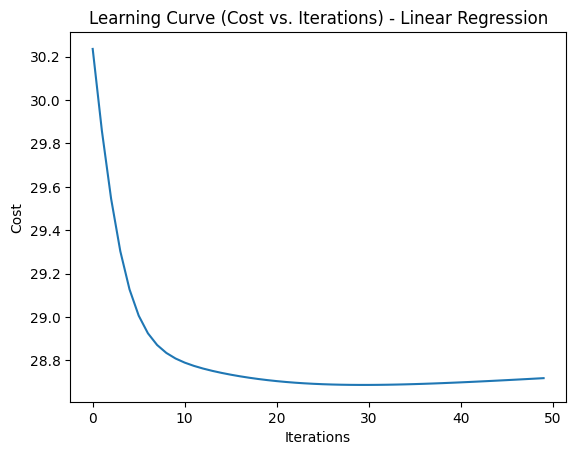

In [637]:
lr.plot_lc(losses)


In [638]:
lr.evaluate(test, test_target)

Loss: 1154750575470.8784 R²: -2.8433


In [639]:
lr.evaluate(valid, valid_target)

Loss: 1070000537490.8643 R²: -122.3316


In [640]:
lr.evaluate(train, train_target)

Loss: 1229981124710.9160 R²: -120.4075


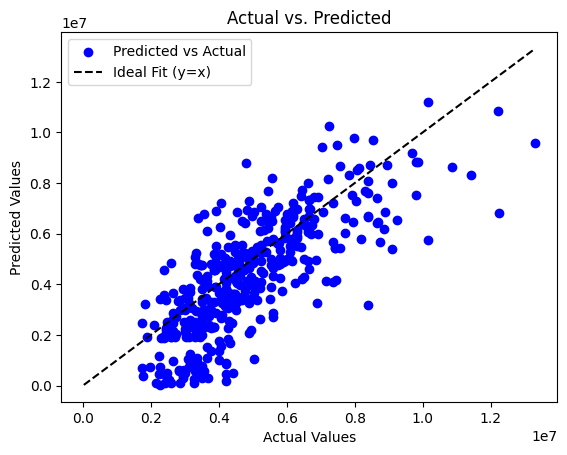

In [641]:
lr.plot(train, train_target)

In [642]:
lr.predict_one(valid, 5)

np.float64(6770555.615188912)

In [643]:
valid_target[5]

np.int64(7875000)

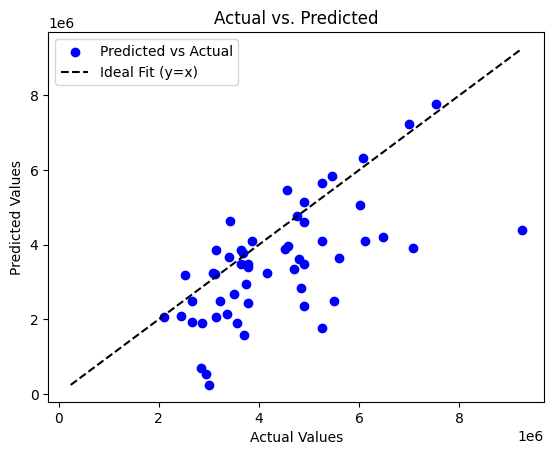

In [644]:
lr.plot(test, test_target)

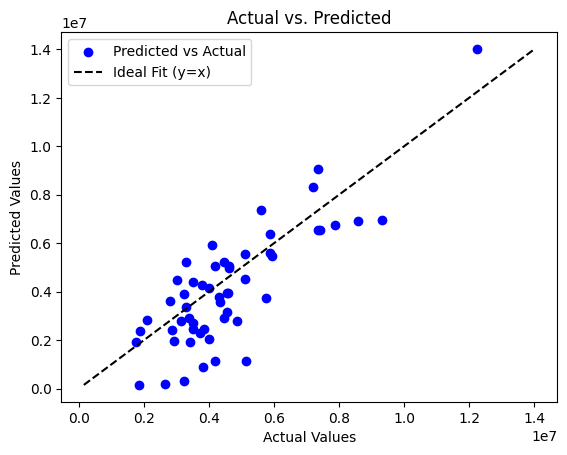

In [645]:
lr.plot(valid, valid_target)